In [21]:
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from glob import glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader,random_split


In [22]:
class DuffingDataset(Dataset):
    def __init__(self, data_dir, window_size=10):
        """
        Args:
            data_dir (str): Directory containing CSV simulation files.
            window_size (int): Number of time steps to use as input for prediction.
        """
        self.window_size = window_size

        # Initialize scalers as attributes (used for normalization and inversion)
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

        # Load and process data
        self.X, self.y = self.create_dataset_from_csv(data_dir)

    def create_dataset_from_csv(self, data_dir):
        """
        Loads Duffing simulation data from CSV files and creates input-output pairs.
        """
        csv_files = sorted(glob(os.path.join(data_dir, "*.csv")))
        X_all, y_all = [], []

        for file in csv_files:
            df = pd.read_csv(file)
            series = df[["x", "v"]].values

            for i in range(len(series) - self.window_size - 1):
                window = series[i:i+self.window_size].flatten()
                target = series[i+self.window_size]

                X_all.append(window)
                y_all.append(target)

        X_all = np.array(X_all)
        y_all = np.array(y_all)

        # Normalize features and targets
        X_scaled = self.scaler_X.fit_transform(X_all)
        y_scaled = self.scaler_y.fit_transform(y_all)

        return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y_scaled, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Testing DuffingDataset class

In [23]:
data_dir = "../data/raw/"
window_size = 10
full_dataset = DuffingDataset(data_dir, window_size)

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)


In [24]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 3321342
Validation size: 711716
Test size: 711717


In [26]:
for name, ds in [("Train", train_dataset), ("Val", val_dataset), ("Test", test_dataset)]:
    x, y = ds[0]
    print(f"{name} sample:")
    print(f"  Input shape: {x.shape} → values: {x[:4]} ...")
    print(f"  Target shape: {y.shape} → values: {y}\n")

Train sample:
  Input shape: torch.Size([20]) → values: tensor([ 0.3750, -0.7254,  0.3665, -0.7228]) ...
  Target shape: torch.Size([2]) → values: tensor([ 0.2910, -0.7021])

Val sample:
  Input shape: torch.Size([20]) → values: tensor([1.6370, 1.2977, 1.6522, 1.2640]) ...
  Target shape: torch.Size([2]) → values: tensor([1.7684, 0.9058])

Test sample:
  Input shape: torch.Size([20]) → values: tensor([-0.8909, -0.2436, -0.8938, -0.2447]) ...
  Target shape: torch.Size([2]) → values: tensor([-0.9203, -0.2512])



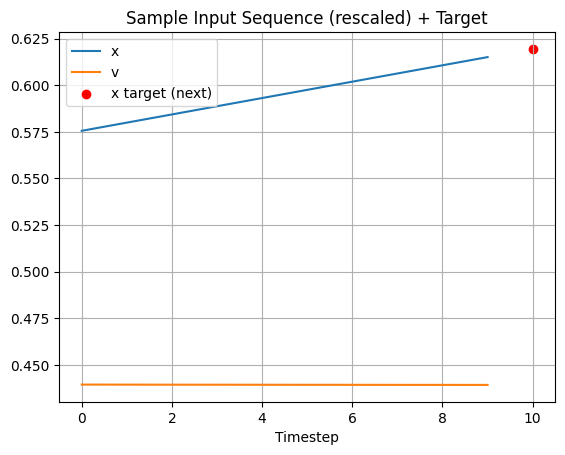

In [42]:
sample_x, sample_y = train_dataset[3330]
x_seq_rescaled = full_dataset.scaler_X.inverse_transform(sample_x.unsqueeze(0).numpy()).reshape(-1, 2)
y_rescaled = full_dataset.scaler_y.inverse_transform(sample_y.unsqueeze(0).numpy())[0]

plt.plot(x_seq_rescaled[:, 0], label="x")
plt.plot(x_seq_rescaled[:, 1], label="v")
plt.scatter(len(x_seq_rescaled), y_rescaled[0], color="red", label="x target (next)")
plt.title("Sample Input Sequence (rescaled) + Target")
plt.xlabel("Timestep")
plt.legend()
plt.grid(True)
plt.show()

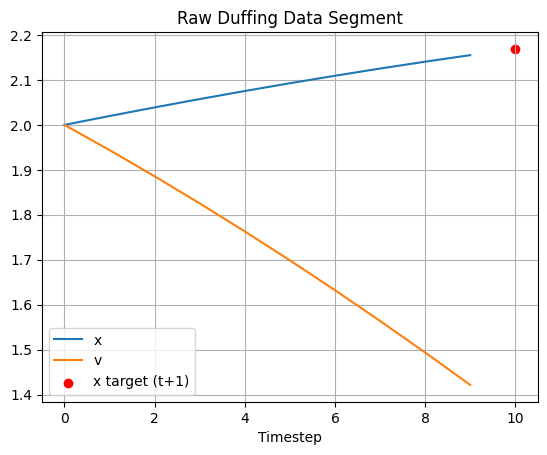

In [46]:
df = pd.read_csv("../data/raw/F0.7_d0.10_w1.2_sim_199.csv")  # update filename as needed
series = df[["x", "v"]].values
i = 0
window_size = 10

segment = series[i:i+window_size+1]
x_seq = segment[:-1, 0]
v_seq = segment[:-1, 1]
x_target = segment[-1, 0]

plt.plot(range(window_size), x_seq, label="x")
plt.plot(range(window_size), v_seq, label="v")
plt.scatter(window_size, x_target, color='red', label="x target (t+1)")
plt.title("Raw Duffing Data Segment")
plt.xlabel("Timestep")
plt.legend()
plt.grid(True)
plt.show()
